Install required modules

In [ ]:
#import pkg_resources
#required = {'gdown', 'transformers', 'pandas', 'torch'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed

#if missing:
#  for module in missing:
#    print('Installing {0}'.format(module))
#    !pip install {module}

#print('Done')

Download and extract GlossBERT dataset


In [ ]:
import os
import gdown 

# Download the file (if we haven't already)
url = 'https://drive.google.com/uc?id=1OA-Ux6N517HrdiTDeGeIZp5xTq74Hucf'
output = './GlossBERT_datasets.zip'
if not os.path.exists(output):
  print('Downloading dataset...')
  gdown.download(url, output, quiet=False)

# Unzip the dataset (if we haven't already)
if not os.path.exists('./GlossBERT_datasets'):
    print('Uncompressing dataset...')
    !unzip GlossBERT_datasets.zip -d './GlossBERT_datasets'

print('Done')

In [1]:
import pandas as pd

#if 'dataset' not in globals():
print('Loading GlossBERT dataset...')
dataset = pd.read_csv('GlossBERT_datasets/Training_Corpora/SemCor/semcor_train_sent_cls.csv', delimiter='\t', header=0)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(dataset.shape[0]))

# Display 10 random rows from the data.
dataset.sample(10)

# Get the lists of sentences, glosses and their labels.
sentences = dataset.sentence.values.tolist()
glosses = dataset.gloss.values.tolist()
labels = dataset.label.values.tolist()
print(f'{len(sentences)} sentences, {len(glosses)} glosses, {len(labels)} labels')

empty_sentences = [s for s in sentences if not s.strip()]
empty_glosses = [g for g in glosses if not g.strip()]
empty_labels = [l for l in labels if not l]
print(f'{len(empty_sentences)} empty sentences, {len(empty_glosses)} empty glosses, {len(empty_labels)} empty labels')

print('Done')

Loading GlossBERT dataset...
Number of training sentences: 2,021,762

2021762 sentences, 2021762 glosses, 2021762 labels
0 empty sentences, 0 empty glosses, 1795067 empty labels
Done


In [ ]:
  dataset.sample(10)


0.00976326590370182 ratio of pairs of length > 100
0.001357726577114418 ratio of pairs of length > 150


<AxesSubplot:ylabel='Frequency'>

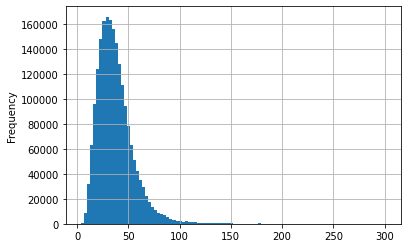

In [2]:
import matplotlib.pyplot as plt

tokenized_sentences = list(map(str.split, sentences)) # exact value, sentences are tokenized
tokenized_glosses = list(map(str.split, glosses)) # approximation, glosses aren't tokenized
lengths = [len(s) + len(g) for (s,g) in zip(tokenized_sentences, tokenized_glosses)]
long_100 = [l for l in lengths if l > 100]
long_150 = [l for l in lengths if l > 150]
print(f"{len(long_100)/len(lengths)} ratio of pairs of length > 100")
print(f"{len(long_150)/len(lengths)} ratio of pairs of length > 150")
histogram = pd.Series(lengths)
histogram.plot.hist(grid=True, bins=100)

Preparet sentences and glosses for BERT

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

print('Done')

In [ ]:
from transformers import BertTokenizer

if 'tokenizer' not in globals():
  print('Loading BERT tokenizer...')
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print('Done')

Prepare Torch

In [ ]:
# max_len = 0

# # For every sentence...
# for gloss in glosses:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(gloss, add_special_tokens=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max gloss length: ', max_len)

Get info about length of sentence-gloss pairs

In [ ]:
#deserialize 

os.path.isfile
import cPickle as pickle

infile = open('input_ids','rb')
input_ids = pickle.load(infile)
infile.close()


filename = 'input_ids'
outfile = open(filename,'wb')
pickle.dump(input_ids,outfile)
outfile.close()

filename = 'attention_masks'
outfile = open(filename,'wb')
pickle.dump(attention_masks,outfile)
outfile.close()

filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(labels,outfile)
outfile.close()

In [8]:
import time
import itertools

print('Preparting BERT input...')

#if 'encoded_dict' not in globals():
input_ids = []
attention_masks = []

start_time = time.time()
counter = 0

for (sent, gloss) in itertools.islice(zip(sentences, glosses), len(sentences)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                      sent,       # sentences are tokenized, so split by whitespace
                      gloss,               # glosses require tokenization
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      padding = 'max_length', truncation = True, max_length = 100, # Pad & truncate all sentences.
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt'     # Return pytorch tensors.
                 )
          
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
       
    counter += 1
    if counter % 100000 == 0:
        print(f'...{counter} in {time.time() - start_time}')

print("Elapsed time: ", time.time() - start_time)
print('Done')

Preparting BERT input...
...100000 in 53.93090605735779
...200000 in 107.51079082489014
...300000 in 160.43732357025146
...400000 in 218.2447211742401
...500000 in 273.28300070762634
...600000 in 329.45314359664917
...700000 in 383.1976056098938
...800000 in 435.7556347846985
...900000 in 490.1077370643616
...1000000 in 539.4152309894562
...1100000 in 596.2664041519165
...1200000 in 647.8074588775635
...1300000 in 707.2021517753601
...1400000 in 758.5288207530975
...1500000 in 808.7302675247192
...1600000 in 857.992746591568
...1700000 in 909.5448575019836
...1800000 in 957.4890985488892
...1900000 in 1006.9866216182709
...2000000 in 1055.7544312477112
Elapsed time:  1067.9026670455933
Done


In [ ]:
#serialize 
import bz2
import cPickle as pickle

outfile = bz2.BZ2File('input_ids','w')
pickle.dump(input_ids,outfile)
outfile.close()

outfile = bz2.BZ2File('attention_masks','w')
pickle.dump(attention_masks,outfile)
outfile.close()

outfile = bz2.BZ2File('labels','w')
pickle.dump(labels,outfile)
outfile.close()


In [9]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Done')

Done


In [10]:
# Print first pair and
print(f'Sentence: {sentences[0]}')
print(f'Gloss: {glosses[0]}')
print(f'Token IDs: {input_ids[0]}')
print(f'Attention maks: {attention_masks[0]}')
print(f'Label: {labels[0]}')

Sentence: How long has it been since you reviewed the objectives of your benefit and service program ?
Gloss: desire strongly or persistently
Token IDs: tensor([  101,  2129,  2146,  2038,  2009,  2042,  2144,  2017,  8182,  1996,
        11100,  1997,  2115,  5770,  1998,  2326,  2565,  1029,   102,  4792,
         6118,  2030, 14516,  2135,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention maks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Training and validation split

In [11]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('Done')

1,819,585 training samples
202,177 validation samples
Done


In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
print('Done')

Done


Train classification model

In [13]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
print('Done')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Done


In [14]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('Done')    

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Optimizer & Learning rate scheduler

In [15]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
print('Done')    

Done


In [16]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
print('Done')    

Done


Training loop

In [17]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
print('Done')    

Done


In [18]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
print('Done')    

Done


In [19]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('Done')    


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  113,725.    Elapsed: 0:00:11.
  Batch    80  of  113,725.    Elapsed: 0:00:22.
  Batch   120  of  113,725.    Elapsed: 0:00:32.
  Batch   160  of  113,725.    Elapsed: 0:00:43.
  Batch   200  of  113,725.    Elapsed: 0:00:54.
  Batch   240  of  113,725.    Elapsed: 0:01:05.
  Batch   280  of  113,725.    Elapsed: 0:01:16.
  Batch   320  of  113,725.    Elapsed: 0:01:27.
  Batch   360  of  113,725.    Elapsed: 0:01:39.
  Batch   400  of  113,725.    Elapsed: 0:01:50.
  Batch   440  of  113,725.    Elapsed: 0:02:02.
  Batch   480  of  113,725.    Elapsed: 0:02:14.
  Batch   520  of  113,725.    Elapsed: 0:02:25.
  Batch   560  of  113,725.    Elapsed: 0:02:36.
  Batch   600  of  113,725.    Elapsed: 0:02:47.
  Batch   640  of  113,725.    Elapsed: 0:02:59.
  Batch   680  of  113,725.    Elapsed: 0:03:10.
  Batch   720  of  113,725.    Elapsed: 0:03:22.
  Batch   760  of  113,725.    Elapsed: 0:03:34.
  Batch   800  of  113,725

In [23]:
# Save model
model.eval()
torch.save(model.state_dict(), '/home/gerard/ownCloud/varis_tesi/GlossBERT_datasets/SemCor.pt')
torch.save(model, '/home/gerard/ownCloud/varis_tesi/GlossBERT_datasets/SemCor_full.pt')
print('Done')   

Done


In [20]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.22,0.22,0.93,8:36:19,0:16:34
2,0.19,0.20,0.94,8:28:17,0:16:32
3,0.16,0.20,0.94,8:38:41,0:17:05
4,0.14,0.22,0.94,8:33:03,0:16:31


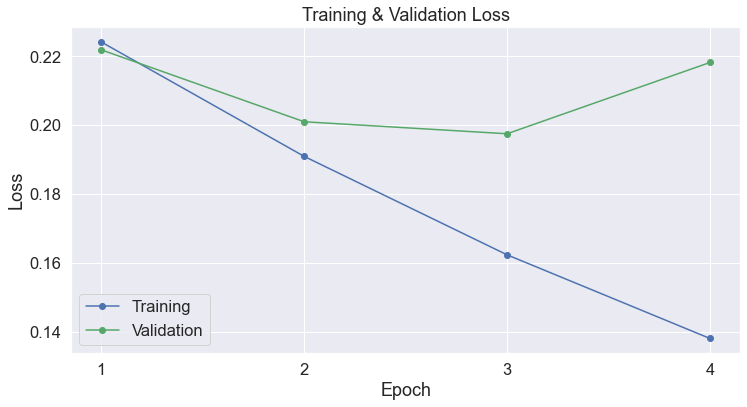

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Performance on test set

attention_masks

In [28]:
import pandas as pd

# Load the dataset into a pandas dataframe.
dataset_test = pd.read_csv('GlossBERT_datasets/Evaluation_Datasets/ALL/ALL_test_sent_cls.csv', delimiter='\t', header=0)

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(dataset_test.shape[0]))

# Create sentence and label lists
sentences_test = dataset_test.sentence.values
glosses_test = dataset_test.gloss.values.tolist()
labels_test = dataset_test.label.values

print('Preparting BERT test input...')

#if 'encoded_dict' not in globals():
input_ids_test = []
attention_masks_test = []


start_time = time.time()
counter = 0

for (sent, gloss) in itertools.islice(zip(sentences_test, glosses_test), len(sentences_test)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                      sent,       # sentences are tokenized, so split by whitespace
                      gloss,               # glosses require tokenization
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      padding = 'max_length', truncation = True, max_length = 100, # Pad & truncate all sentences.
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt'     # Return pytorch tensors.
                 )
        
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])
    
    counter += 1
    if counter % 10000 == 0:
        print(f'...{counter} in {time.time() - start_time}')

print("Elapsed time: ", time.time() - start_time)

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
print('Done')

Number of test sentences: 58,021

Preparting BERT test input...
Elapsed time:  30.2389657497406
Done


In [1]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

NameError: name 'input_ids_test' is not defined